In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
import warnings
warnings.filterwarnings('ignore')
import datetime as dt

In [2]:
import xgboost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split,cross_validate,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import roc_curve # 绘制ROC曲线
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score,f1_score,recall_score,precision_score
import matplotlib.pyplot as plt
%matplotlib inline

# 一、EDA

In [3]:
# 导入数据
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
financial_data = train_data
financial_data# 查看缺失值

,policy_id,age,customer_months,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud
0,122576,37,189,2013-08-21,C,500/1000,1000,1465.71,5000000,455456,...,3,?,54930,6029,5752,44452,Nissan,Maxima,2000,0
1,937713,44,234,1998-01-04,B,250/500,500,821.24,0,591805,...,1,YES,50680,5376,10156,37347,Honda,Civic,1996,0
2,680237,33,23,1996-02-06,B,500/1000,1000,1844.00,0,442490,...,1,NO,47829,4460,9247,33644,Jeep,Wrangler,2002,0
3,513080,42,210,2008-11-14,A,500/1000,500,1867.29,0,439408,...,2,YES,68862,11043,5955,53548,Suburu,Legacy,2003,1
4,192875,29,81,2002-01-08,A,100/300,1000,816.25,0,640575,...,1,YES,59726,5617,10301,41550,Ford,F150,2004,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,1008425,37,196,1997-06-29,C,250/500,500,1301.20,0,474615,...,3,NO,61433,10436,11432,39745,Nissan,Pathfinder,2011,1
696,770702,43,229,2001-05-29,A,250/500,500,1434.94,8000000,444476,...,1,?,68623,6798,14557,50606,Volkswagen,Passat,2013,1
697,755099,35,209,2003-01-11,C,100/300,500,1639.46,0,639608,...,0,YES,58033,9129,4598,40740,Mercedes,C300,2002,0
698,693804,44,275,2003-07-22,B,500/1000,2000,1042.29,0,432061,...,0,NO,35253,7359,3464,24677,Audi,A3,2007,1


# 1.数据结构探索

区分离散型变量和连续型变量

In [4]:
numercial_feature = list(financial_data.select_dtypes(exclude=['object']).columns) #数值型变量
object_feature = list(financial_data.select_dtypes(include=['object']).columns)
numercial_feature,object_feature

(['policy_id',
  'age',
  'customer_months',
  'policy_deductable',
  'policy_annual_premium',
  'umbrella_limit',
  'insured_zip',
  'capital-gains',
  'capital-loss',
  'incident_hour_of_the_day',
  'number_of_vehicles_involved',
  'bodily_injuries',
  'witnesses',
  'total_claim_amount',
  'injury_claim',
  'property_claim',
  'vehicle_claim',
  'auto_year',
  'fraud'],
 ['policy_bind_date',
  'policy_state',
  'policy_csl',
  'insured_sex',
  'insured_education_level',
  'insured_occupation',
  'insured_hobbies',
  'insured_relationship',
  'incident_date',
  'incident_type',
  'collision_type',
  'incident_severity',
  'authorities_contacted',
  'incident_state',
  'incident_city',
  'property_damage',
  'police_report_available',
  'auto_make',
  'auto_model'])

In [5]:
# 连续型变量
serial_feature = []
# 离散型变量
discrete_feature = []
# 单值变量
unique_feature = []

for feature in numercial_feature:
    temp = financial_data[feature].nunique() #返回数据去重后的个数
    if temp == 1:
        unique_feature.append(feature)
    elif temp >1 and temp <= 10:
        discrete_feature.append(feature)
    else:
        serial_feature.append(feature)

# 2 连续型变量

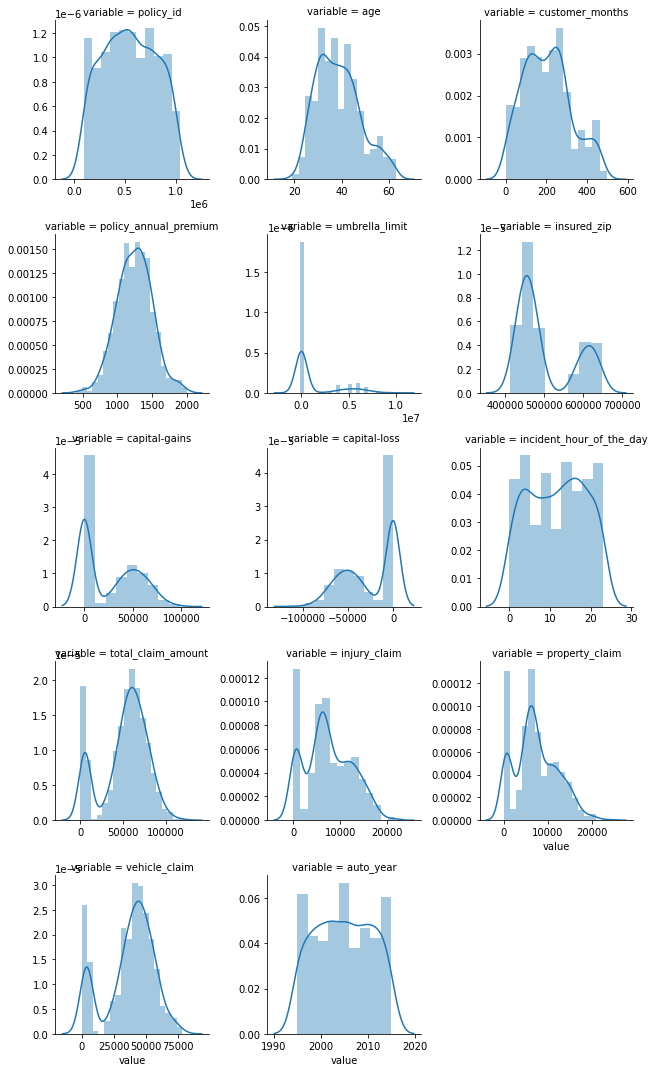

In [6]:
serial_df = pd.melt(financial_data,value_vars=serial_feature) #将连续型变量融合在一个dataframe中
f = sns.FacetGrid(serial_df,col='variable',col_wrap=3, sharex=False, sharey=False) # 生成画布，最多三列，不共享x、y轴
f.map(sns.distplot,"value")

Text(0, 0.5, 'Density')

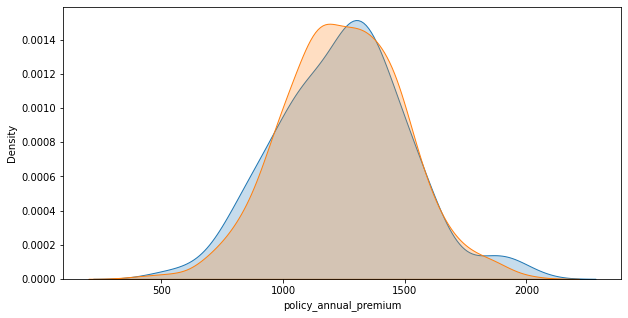

In [7]:
# 单独查看每年保费分布
plt.figure(figsize=(10,5))
sns.kdeplot(financial_data.policy_annual_premium[financial_data['fraud'] == 1],shade=True)# 违约者
sns.kdeplot(financial_data.policy_annual_premium[financial_data['fraud'] == 0],shade=True)# 没有违约
plt.xlabel('policy_annual_premium')
plt.ylabel('Density')

<AxesSubplot:xlabel='capital-loss', ylabel='Density'>

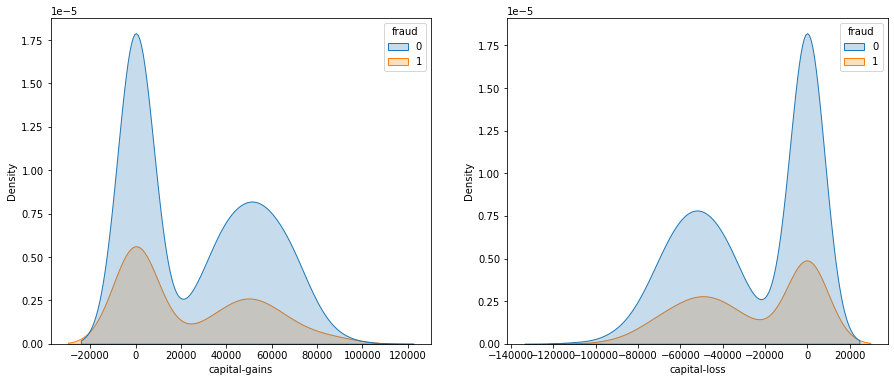

In [8]:
# 查看资本利得损失变化
fig,axes = plt.subplots(1,2,figsize=(15,6))
sns.kdeplot(financial_data['capital-gains'],hue=financial_data['fraud'],shade=True,ax=axes[0])
sns.kdeplot(financial_data['capital-loss'],hue=financial_data['fraud'],shade=True,ax=axes[1])

Text(0, 0.5, 'Density')

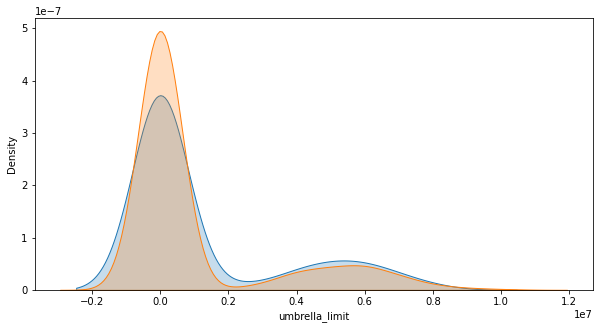

In [9]:
plt.figure(figsize=(10,5))
sns.kdeplot(financial_data.umbrella_limit[financial_data['fraud'] == 1],shade=True)# 违约者
sns.kdeplot(financial_data.umbrella_limit[financial_data['fraud'] == 0],shade=True)# 没有违约
plt.xlabel('umbrella_limit')
plt.ylabel('Density')

# 3.离散型变量

In [10]:
for val in discrete_feature:
    temp = financial_data[val].nunique()
    print(val,'类型数',temp)

policy_deductable 类型数 3
number_of_vehicles_involved 类型数 4
bodily_injuries 类型数 3
witnesses 类型数 4
fraud 类型数 2


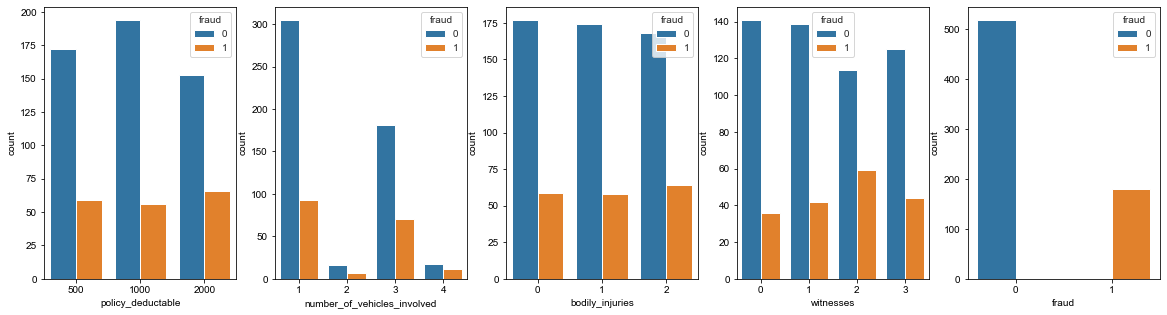

In [11]:
# 绘制频数图
discrete_df = financial_data[discrete_feature]
fig,axes = plt.subplots(1,5,figsize=(20,5))
sns.set_style('whitegrid')
for i,val in enumerate(discrete_feature):
    sns.countplot(data=discrete_df,x=val,hue='fraud',ax=axes[i])

# 4.分类型变量

In [12]:
object_feature
financial_data[object_feature]
# 变量有日期型、缺失值

,policy_bind_date,policy_state,policy_csl,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,property_damage,police_report_available,auto_make,auto_model
0,2013-08-21,C,500/1000,FEMALE,Masters,protective-serv,reading,not-in-family,2014-12-22,Single Vehicle Collision,Side Collision,Total Loss,Ambulance,S5,Riverwood,?,?,Nissan,Maxima
1,1998-01-04,B,250/500,MALE,JD,craft-repair,polo,other-relative,2015-02-18,Multi-vehicle Collision,Side Collision,Minor Damage,Other,S5,Springfield,?,YES,Honda,Civic
2,1996-02-06,B,500/1000,FEMALE,High School,machine-op-inspct,skydiving,wife,2015-01-18,Single Vehicle Collision,Side Collision,Total Loss,Police,S3,Northbend,?,NO,Jeep,Wrangler
3,2008-11-14,A,500/1000,MALE,JD,transport-moving,video-games,own-child,2015-02-02,Multi-vehicle Collision,Front Collision,Major Damage,Fire,S3,Northbend,YES,YES,Suburu,Legacy
4,2002-01-08,A,100/300,FEMALE,MD,craft-repair,video-games,own-child,2015-02-09,Multi-vehicle Collision,Rear Collision,Total Loss,Fire,S2,Northbend,YES,YES,Ford,F150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,1997-06-29,C,250/500,MALE,JD,tech-support,video-games,wife,2015-01-18,Single Vehicle Collision,Front Collision,Major Damage,Ambulance,S5,Columbus,?,NO,Nissan,Pathfinder
696,2001-05-29,A,250/500,MALE,College,machine-op-inspct,golf,husband,2015-01-13,Multi-vehicle Collision,Rear Collision,Major Damage,Ambulance,S1,Arlington,NO,?,Volkswagen,Passat
697,2003-01-11,C,100/300,FEMALE,College,transport-moving,golf,not-in-family,2015-03-05,Multi-vehicle Collision,Rear Collision,Minor Damage,Fire,S2,Riverwood,NO,YES,Mercedes,C300
698,2003-07-22,B,500/1000,FEMALE,Associate,machine-op-inspct,paintball,other-relative,2015-01-09,Multi-vehicle Collision,Rear Collision,Major Damage,Ambulance,S5,Northbend,?,NO,Audi,A3


In [13]:
financial_data[object_feature].isna().any(axis=0)
# collision_type、property_damage、police_report_available有缺失值

policy_bind_date           False
policy_state               False
policy_csl                 False
insured_sex                False
insured_education_level    False
insured_occupation         False
insured_hobbies            False
insured_relationship       False
incident_date              False
incident_type              False
collision_type             False
incident_severity          False
authorities_contacted      False
incident_state             False
incident_city              False
property_damage            False
police_report_available    False
auto_make                  False
auto_model                 False
dtype: bool

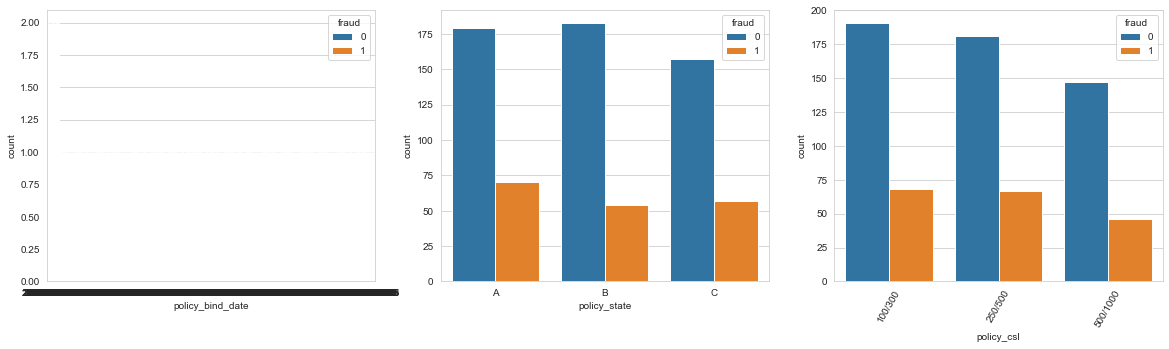

In [14]:
category_df = pd.concat([financial_data[object_feature],financial_data[discrete_feature[-1]]],axis=1)
n = len(object_feature) // 6
fig,axes = plt.subplots(1,n,figsize=(20,5))
sns.set_style('whitegrid')
for i,val in enumerate(object_feature[0:n]):
    sns.countplot(data=category_df,x=val,hue='fraud',ax=axes[i],order=category_df[val].value_counts().index)
    plt.xticks(rotation=60)
    
# fig,axes = plt.subplots(1,n,figsize=(20,5))
# for i,val in enumerate(object_feature[n:n+n]):
#    sns.countplot(data=category_df,x=val,hue='fraud',ax=axes[i],order=category_df[val].value_counts().index)
#    plt.xticks(rotation=60)
    
# fig,axes = plt.subplots(1,n,figsize=(20,5))
# for i,val in enumerate(object_feature[2*n:3*n-1]):
#    sns.countplot(data=category_df,x=val,hue='fraud',ax=axes[i],order=category_df[val].value_counts().index)
#    plt.xticks(rotation=60)

# 6.缺失值的处理

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36]),
 [Text(0, 0, 'policy_id'),
  Text(1, 0, 'age'),
  Text(2, 0, 'customer_months'),
  Text(3, 0, 'policy_bind_date'),
  Text(4, 0, 'policy_state'),
  Text(5, 0, 'policy_csl'),
  Text(6, 0, 'policy_deductable'),
  Text(7, 0, 'policy_annual_premium'),
  Text(8, 0, 'umbrella_limit'),
  Text(9, 0, 'insured_zip'),
  Text(10, 0, 'insured_sex'),
  Text(11, 0, 'insured_education_level'),
  Text(12, 0, 'insured_occupation'),
  Text(13, 0, 'insured_hobbies'),
  Text(14, 0, 'insured_relationship'),
  Text(15, 0, 'capital-gains'),
  Text(16, 0, 'capital-loss'),
  Text(17, 0, 'incident_date'),
  Text(18, 0, 'incident_type'),
  Text(19, 0, 'collision_type'),
  Text(20, 0, 'incident_severity'),
  Text(21, 0, 'authorities_contacted'),
  Text(22, 0, 'incident_state'),
  Text(23, 0, 'incident_city'),
  Text(24, 0, 'incident_hour_of_the

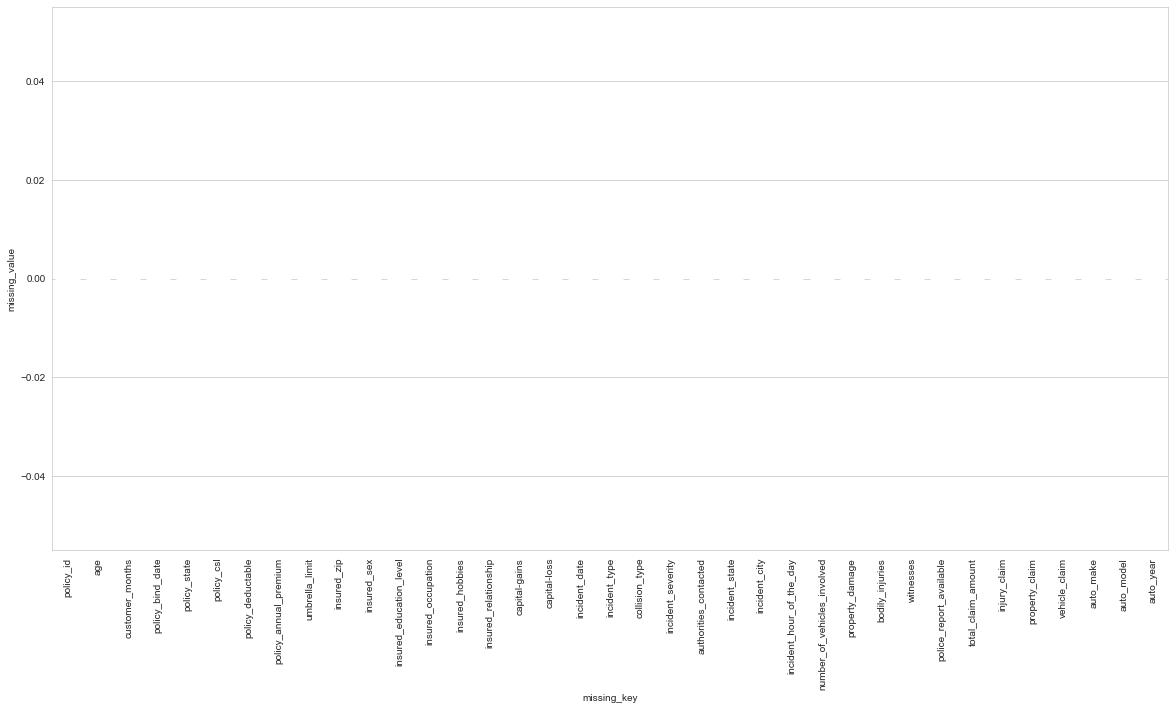

In [15]:
X_missing = financial_data.drop(columns='fraud')
missing = X_missing.isna().mean()
missing_df = pd.DataFrame({'missing_key':missing.keys(),'missing_value':np.round(missing.values,4)})
plt.figure(figsize=(20,10))
sns.barplot(data=missing_df,x='missing_key',y='missing_value')
plt.xticks(rotation=90)
# 缺失值都不超过50%，所以我们进行填充缺失值

# 7.变量相关性

<AxesSubplot:>

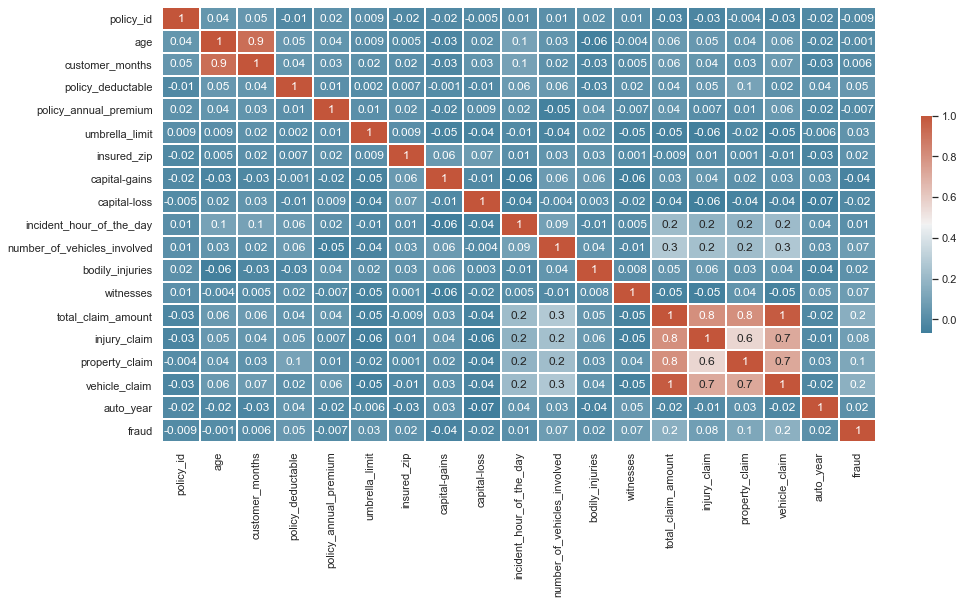

In [16]:
cor = financial_data[numercial_feature].corr()
sns.set_theme(style="white")
plt.figure(figsize=(16,8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(cor,cmap=cmap,annot = True,linewidth = 0.2, 
            cbar_kws={"shrink": .5},linecolor = "white",fmt =".1g")

# 三、特征工程

1.缺失值的填充

对于分类型变量使用众数进行填充

对于连续型变量使用均值或中位数进行填充，区别在于分布是否偏态

In [17]:
missing_df

,missing_key,missing_value
0,policy_id,0.0
1,age,0.0
2,customer_months,0.0
3,policy_bind_date,0.0
4,policy_state,0.0
5,policy_csl,0.0
6,policy_deductable,0.0
7,policy_annual_premium,0.0
8,umbrella_limit,0.0
9,insured_zip,0.0


In [18]:
missing_feature = list(missing_df[missing_df['missing_value'] != 0].missing_key) # 有缺失值的特征
financial_data[missing_feature] # 可以看出来都是分类型变量
for val in missing_feature:
    train_data[val] = train_data[val].fillna(train_data[val].mode()[0])
    test_data[val] = test_data[val].fillna(test_data[val].mode()[0])

2.异常值的处理

异常值通过3σ或者箱线图来确定

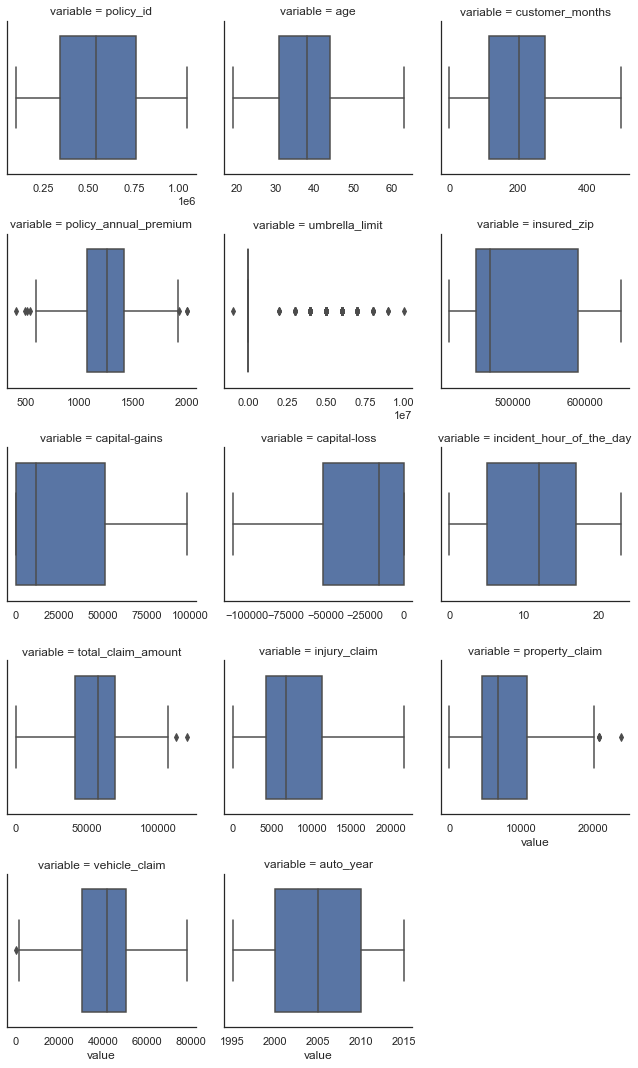

In [19]:
f_box = sns.FacetGrid(serial_df,col='variable',col_wrap=3, sharex=False, sharey=False) # 生成画布，最多三列，不共享x、y轴
f_box.map(sns.boxplot,"value") # 发现存在变量有异常 由于是特殊的风险预测，所以保留异常值

3.时间数据的处理

主要对日期进行拆分

In [20]:
datetime_list = ['policy_bind_date','incident_date']
financial_data[['policy_bind_date','incident_date']]
# 我们基于出险日期和保险绑定日期做一个差值，并取出出险日期作为单独的字段

,policy_bind_date,incident_date
0,2013-08-21,2014-12-22
1,1998-01-04,2015-02-18
2,1996-02-06,2015-01-18
3,2008-11-14,2015-02-02
4,2002-01-08,2015-02-09
...,...,...
695,1997-06-29,2015-01-18
696,2001-05-29,2015-01-13
697,2003-01-11,2015-03-05
698,2003-07-22,2015-01-09


<AxesSubplot:xlabel='detla_time', ylabel='Density'>

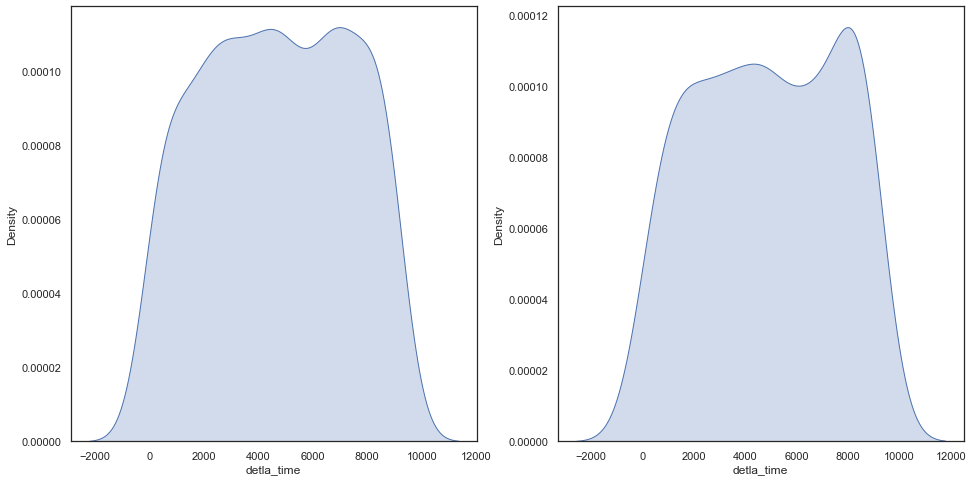

In [21]:
import datetime

for val in datetime_list:
    train_data[val] = pd.to_datetime(train_data[val],format='%Y-%m-%d')
    test_data[val] = pd.to_datetime(test_data[val], format='%Y-%m-%d')
# 转化时间格式


# 创建新特征，两个日期之差
train_data['detla_time'] = (train_data['incident_date'] - train_data['policy_bind_date']).dt.days
test_data['detla_time'] = (test_data['incident_date'] - test_data['policy_bind_date']).dt.days


fig,axes = plt.subplots(1,2,figsize=(16,8))
sns.kdeplot(train_data['detla_time'],shade=True,ax=axes[0])
sns.kdeplot(test_data['detla_time'],shade=True,ax=axes[1])
# 分布良好

In [22]:
train_data['picked_month'] = train_data['incident_date'].dt.month
test_data['picked_month'] = test_data['incident_date'].dt.month
train_data['picked_month'] = train_data['picked_month'].apply(lambda x: str(x) + '月')
test_data['picked_month'] = test_data['picked_month'].apply(lambda x: str(x) + '月')
# 将数字处理成字符，因为我们不在意大小而在于出现的频次


train_data.drop(columns=['policy_bind_date','incident_date'],inplace=True)
test_data.drop(columns=['policy_bind_date','incident_date'],inplace=True)# 删除两个日期型feature


object_feature.remove('policy_bind_date')
object_feature.remove('incident_date')
object_feature.append('picked_month')
numercial_feature.append('detla_time')

# 4.特征选择

In [23]:
train_data = train_data.drop(columns='policy_id')
test_data = test_data.drop(columns='policy_id')# 删除id字段

train_data.corr()['fraud'].sort_values # 查看变量与fraud的相关系数
# 决定全部保留

<bound method Series.sort_values of age                           -0.001386
customer_months                0.005680
policy_deductable              0.051987
policy_annual_premium         -0.006739
umbrella_limit                 0.031321
insured_zip                    0.024838
capital-gains                 -0.041130
capital-loss                  -0.017276
incident_hour_of_the_day       0.014834
number_of_vehicles_involved    0.071055
bodily_injuries                0.024079
witnesses                      0.072243
total_claim_amount             0.155167
injury_claim                   0.082015
property_claim                 0.120906
vehicle_claim                  0.164941
auto_year                      0.019323
fraud                          1.000000
detla_time                     0.021705
Name: fraud, dtype: float64>

In [24]:
# 显示相关性高于0.6的变量
def getHighRelatedFeatureDf(corr_matrix, corr_threshold):
    highRelatedFeatureDf = pd.DataFrame(corr_matrix[corr_matrix > corr_threshold].stack().reset_index())
    highRelatedFeatureDf.rename({'level_0':'feature1','level_1':'feature2',0:'corr'},axis=1,inplace=True) # 更改列名
    highRelatedFeatureDf = highRelatedFeatureDf[highRelatedFeatureDf.feature1 != highRelatedFeatureDf.feature2] # 去除自己和自己
    highRelatedFeatureDf['feature_pair_key'] = highRelatedFeatureDf.loc[:,['feature1', 'feature2']].apply(lambda r:'#'.join(np.sort(r.values)), axis=1)
    # 将feature1和feature2名称连接在一起去重
    highRelatedFeatureDf.drop_duplicates(subset=['feature_pair_key'],inplace=True)
    highRelatedFeatureDf.drop(columns='feature_pair_key',inplace=True)
    return highRelatedFeatureDf

getHighRelatedFeatureDf(train_data.corr(),0.6)
# age和moth有明显相关性，删除age(与fraud相关性不高)
# 删除injury_claim

numercial_feature.remove('age')
numercial_feature.remove('policy_id')
numercial_feature.remove('injury_claim')

# 5.特征编码

In [25]:
y_label = train_data['fraud']
train_data = train_data.drop(columns='fraud')
train_data

,age,customer_months,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,detla_time,picked_month
0,37,189,C,500/1000,1000,1465.71,5000000,455456,FEMALE,Masters,...,?,54930,6029,5752,44452,Nissan,Maxima,2000,488,12月
1,44,234,B,250/500,500,821.24,0,591805,MALE,JD,...,YES,50680,5376,10156,37347,Honda,Civic,1996,6254,2月
2,33,23,B,500/1000,1000,1844.00,0,442490,FEMALE,High School,...,NO,47829,4460,9247,33644,Jeep,Wrangler,2002,6921,1月
3,42,210,A,500/1000,500,1867.29,0,439408,MALE,JD,...,YES,68862,11043,5955,53548,Suburu,Legacy,2003,2271,2月
4,29,81,A,100/300,1000,816.25,0,640575,FEMALE,MD,...,YES,59726,5617,10301,41550,Ford,F150,2004,4780,2月
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,37,196,C,250/500,500,1301.20,0,474615,MALE,JD,...,NO,61433,10436,11432,39745,Nissan,Pathfinder,2011,6412,1月
696,43,229,A,250/500,500,1434.94,8000000,444476,MALE,College,...,?,68623,6798,14557,50606,Volkswagen,Passat,2013,4977,1月
697,35,209,C,100/300,500,1639.46,0,639608,FEMALE,College,...,YES,58033,9129,4598,40740,Mercedes,C300,2002,4436,3月
698,44,275,B,500/1000,2000,1042.29,0,432061,FEMALE,Associate,...,NO,35253,7359,3464,24677,Audi,A3,2007,4189,1月


# MeanEncoder编码

In [26]:
class MeanEncoder:
    def __init__(self, categorical_features, n_splits=5, target_type='classification', prior_weight_func=None):
        """
        :param categorical_features: list of str, the name of the categorical columns to encode

        :param n_splits: the number of splits used in mean encoding

        :param target_type: str, 'regression' or 'classification'

        :param prior_weight_func:
        a function that takes in the number of observations, and outputs prior weight
        when a dict is passed, the default exponential decay function will be used:
        k: the number of observations needed for the posterior to be weighted equally as the prior
        f: larger f --> smaller slope
        """

        self.categorical_features = categorical_features
        self.n_splits = n_splits
        self.learned_stats = {}

        if target_type == 'classification':
            self.target_type = target_type
            self.target_values = []
        else:
            self.target_type = 'regression'
            self.target_values = None

        if isinstance(prior_weight_func, dict):
            self.prior_weight_func = eval('lambda x: 1 / (1 + np.exp((x - k) / f))', dict(prior_weight_func, np=np))
        elif callable(prior_weight_func):
            self.prior_weight_func = prior_weight_func
        else:
            self.prior_weight_func = lambda x: 1 / (1 + np.exp((x - 2) / 1))

    @staticmethod
    def mean_encode_subroutine(X_train, y_train, X_test, variable, target, prior_weight_func):
        X_train = X_train[[variable]].copy()
        X_test = X_test[[variable]].copy()

        if target is not None:
            nf_name = '{}_pred_{}'.format(variable, target)
            X_train['pred_temp'] = (y_train == target).astype(int)  # classification
        else:
            nf_name = '{}_pred'.format(variable)
            X_train['pred_temp'] = y_train  # regression
        prior = X_train['pred_temp'].mean()

        col_avg_y = X_train.groupby(by=variable, axis=0)['pred_temp'].agg([('mean', 'mean'), ('beta', 'size')])
        col_avg_y['beta'] = prior_weight_func(col_avg_y['beta'])
        col_avg_y[nf_name] = col_avg_y['beta'] * prior + (1 - col_avg_y['beta']) * col_avg_y['mean']
        col_avg_y.drop(['beta', 'mean'], axis=1, inplace=True)

        nf_train = X_train.join(col_avg_y, on=variable)[nf_name].values
        nf_test = X_test.join(col_avg_y, on=variable).fillna(prior, inplace=False)[nf_name].values

        return nf_train, nf_test, prior, col_avg_y

    def fit_transform(self, X, y):
        """
        :param X: pandas DataFrame, n_samples * n_features
        :param y: pandas Series or numpy array, n_samples
        :return X_new: the transformed pandas DataFrame containing mean-encoded categorical features
        """
        X_new = X.copy()
        if self.target_type == 'classification':
            skf = StratifiedKFold(self.n_splits)
        else:
            skf = KFold(self.n_splits)

        if self.target_type == 'classification':
            self.target_values = sorted(set(y))
            self.learned_stats = {'{}_pred_{}'.format(variable, target): [] for variable, target in
                                  product(self.categorical_features, self.target_values)}
            for variable, target in product(self.categorical_features, self.target_values):
                nf_name = '{}_pred_{}'.format(variable, target)
                X_new.loc[:, nf_name] = np.nan
                for large_ind, small_ind in skf.split(y, y):
                    nf_large, nf_small, prior, col_avg_y = MeanEncoder.mean_encode_subroutine(
                        X_new.iloc[large_ind], y.iloc[large_ind], X_new.iloc[small_ind], variable, target, self.prior_weight_func)
                    X_new.iloc[small_ind, -1] = nf_small
                    self.learned_stats[nf_name].append((prior, col_avg_y))
        else:
            self.learned_stats = {'{}_pred'.format(variable): [] for variable in self.categorical_features}
            for variable in self.categorical_features:
                nf_name = '{}_pred'.format(variable)
                X_new.loc[:, nf_name] = np.nan
                for large_ind, small_ind in skf.split(y, y):
                    nf_large, nf_small, prior, col_avg_y = MeanEncoder.mean_encode_subroutine(
                        X_new.iloc[large_ind], y.iloc[large_ind], X_new.iloc[small_ind], variable, None, self.prior_weight_func)
                    X_new.iloc[small_ind, -1] = nf_small
                    self.learned_stats[nf_name].append((prior, col_avg_y))
        return X_new

    def transform(self, X):
        """
        :param X: pandas DataFrame, n_samples * n_features
        :return X_new: the transformed pandas DataFrame containing mean-encoded categorical features
        """
        X_new = X.copy()

        if self.target_type == 'classification':
            for variable, target in product(self.categorical_features, self.target_values):
                nf_name = '{}_pred_{}'.format(variable, target)
                X_new[nf_name] = 0
                for prior, col_avg_y in self.learned_stats[nf_name]:
                    X_new[nf_name] += X_new[[variable]].join(col_avg_y, on=variable).fillna(prior, inplace=False)[
                        nf_name]
                X_new[nf_name] /= self.n_splits
        else:
            for variable in self.categorical_features:
                nf_name = '{}_pred'.format(variable)
                X_new[nf_name] = 0
                for prior, col_avg_y in self.learned_stats[nf_name]:
                    X_new[nf_name] += X_new[[variable]].join(col_avg_y, on=variable).fillna(prior, inplace=False)[
                        nf_name]
                X_new[nf_name] /= self.n_splits

        return X_new

In [27]:
train_data[object_feature].nunique() # 对十个以上的变量进行meanencoder

policy_state                3
policy_csl                  3
insured_sex                 2
insured_education_level     7
insured_occupation         14
insured_hobbies            20
insured_relationship        6
incident_type               4
collision_type              4
incident_severity           4
authorities_contacted       5
incident_state              7
incident_city               7
property_damage             3
police_report_available     3
auto_make                  14
auto_model                 39
picked_month                4
dtype: int64

In [30]:
meancoder_list = ['insured_occupation','insured_hobbies','auto_make','auto_model','insured_education_level'
                  ,'incident_state','incident_city']

for val in meancoder_list:
    object_feature.remove(val)
    
    
meanencoder = MeanEncoder(categorical_features=meancoder_list,target_type='classification')
mean_X_train = meanencoder.fit_transform(train_data,y_label)
mean_X_test = meanencoder.transform(test_data)

In [31]:
# 去除meanencoder编码的变量
mean_X_train = mean_X_train.drop(columns=meancoder_list)
mean_X_test = mean_X_test.drop(columns=meancoder_list)

普通编码

In [32]:
from sklearn.preprocessing import LabelEncoder
Label = LabelEncoder()
for val in object_feature:
    Label.fit(mean_X_train[val])
    mean_X_train[val] = Label.transform(mean_X_train[val])
    mean_X_test[val] = Label.transform(mean_X_test[val])
    
mean_X_train

,age,customer_months,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_relationship,...,auto_make_pred_0,auto_make_pred_1,auto_model_pred_0,auto_model_pred_1,insured_education_level_pred_0,insured_education_level_pred_1,incident_state_pred_0,incident_state_pred_1,incident_city_pred_0,incident_city_pred_1
0,37,189,2,2,1000,1465.71,5000000,455456,0,1,...,0.760000,0.240000,0.687500,0.312500,0.787500,0.212500,0.738462,0.261538,0.746667,0.253333
1,44,234,1,1,500,821.24,0,591805,1,2,...,0.687500,0.312500,0.416681,0.583319,0.708333,0.291667,0.738462,0.261538,0.755102,0.244898
2,33,23,1,2,1000,1844.00,0,442490,0,5,...,0.864865,0.135135,0.923077,0.076923,0.765432,0.234568,0.814159,0.185841,0.776316,0.223684
3,42,210,0,2,500,1867.29,0,439408,1,3,...,0.733333,0.266667,0.833333,0.166667,0.708333,0.291667,0.814159,0.185841,0.776316,0.223684
4,29,81,0,0,1000,816.25,0,640575,0,3,...,0.736842,0.263158,0.692309,0.307691,0.671233,0.328767,0.678832,0.321168,0.776316,0.223684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,37,196,2,1,500,1301.20,0,474615,1,5,...,0.777778,0.222222,0.812500,0.187500,0.747368,0.252632,0.765625,0.234375,0.730337,0.269663
696,43,229,0,1,500,1434.94,8000000,444476,1,0,...,0.767442,0.232558,0.782609,0.217391,0.710145,0.289855,0.750000,0.250000,0.724138,0.275862
697,35,209,2,0,500,1639.46,0,639608,0,1,...,0.648649,0.351351,0.340699,0.659301,0.710145,0.289855,0.692308,0.307692,0.750000,0.250000
698,44,275,1,2,2000,1042.29,0,432061,0,2,...,0.681818,0.318182,0.666667,0.333333,0.821429,0.178571,0.765625,0.234375,0.750000,0.250000


# 四、构建模型

In [33]:
# 划分数据集为测试集和训练集
X_train,X_test,y_train,y_test = train_test_split(mean_X_train,y_label,train_size=0.7)
#simple_X_train,simple_X_test,simple_y_train,simple_y_test = train_test_split(simple_X,simple_y,train_size=0.7)

In [34]:
# 集合算法树模型
GBDT_param = {
    'loss':'log_loss',
    'learning_rate':0.1,
    'n_estimators':30,
    'max_depth':3,
    'min_samples_split':300
}
GBDT_clf = GradientBoostingClassifier()# GBDT模型

tree_param = {
    'criterion': 'gini',
    'max_depth': 30,
    'min_impurity_decrease': 0.1,
    'min_samples_leaf': 2
    
}
Tree_clf = DecisionTreeClassifier(**tree_param) # 决策树模型

xgboost_param = {
    'learning_rate':0.01,
    'reg_alpha':0.,
    'max_depth':3,
    'gamma':0,
    'min_child_weight':1
    
}
xgboost_clf = xgboost.XGBClassifier(**xgboost_param) # xgboost模型

xgboost_clf.fit(X_train,y_train)
GBDT_clf.fit(X_train,y_train) 
Tree_clf.fit(X_train,y_train)

[18:23:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


DecisionTreeClassifier(max_depth=30, min_impurity_decrease=0.1,
                       min_samples_leaf=2)

In [35]:
# K折交叉检验
K_model_list = [Tree_clf,GBDT_clf,xgboost_clf]
K_result = pd.DataFrame()
for i,val in enumerate(K_model_list):
    score = cross_validate(val,mean_X_train,y_label,cv=6,scoring='accuracy')
    K_result.loc[i,'accuracy'] = score['test_score'].mean()
K_result.index = pd.Series(['Tree','GBDT','XGBoost'])
K_result

[18:23:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:23:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:23:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:23:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,accuracy
Tree,0.741428
GBDT,0.817160
XGBoost,0.828532


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

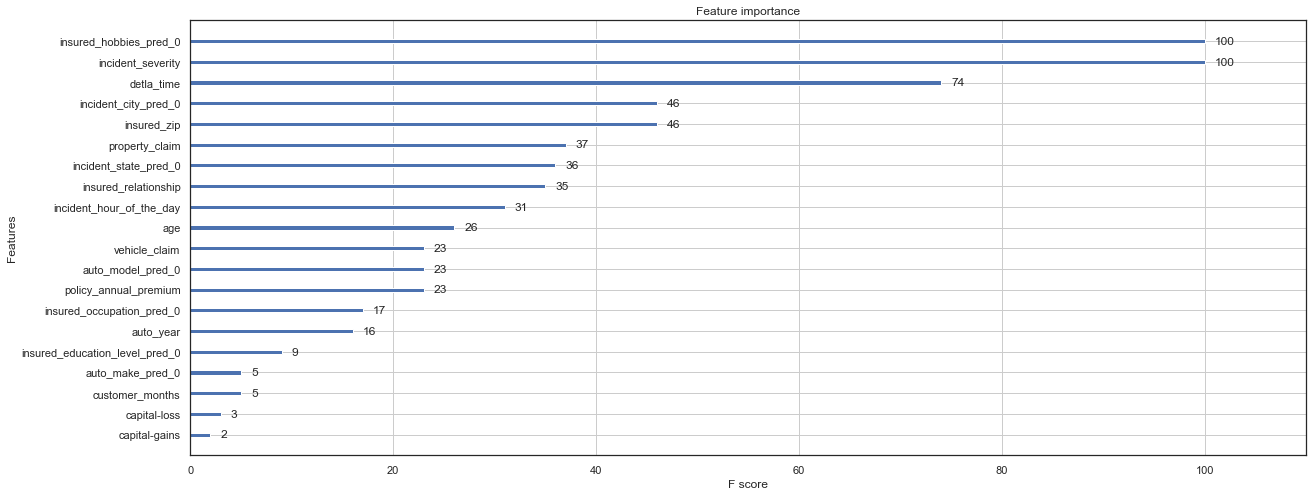

In [36]:
# 特征重要性排序
from xgboost import plot_importance
fig,ax = plt.subplots(figsize=(20,8))
plot_importance(xgboost_clf,ax=ax)